In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from arcgis.gis import GIS

### Source Dataset

In [2]:
# read time-series csv
usa_ts_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
usa_ts_df = pd.read_csv(usa_ts_url, header=0, escapechar='\\')
usa_ts_df.head(5)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,15821,15826,15827,15827,15827,15833,15835,15839,15840,15840
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,55623,55633,55643,55643,55643,55664,55685,55695,55713,55730
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,5664,5665,5668,5668,5668,5670,5671,5671,5671,5672
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,6438,6439,6442,6442,6442,6442,6442,6443,6444,6444
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,14976,14977,14980,14980,14980,14979,14981,14983,14985,14985


In [3]:
usa_ts_df.columns

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_',
       ...
       '4/27/22', '4/28/22', '4/29/22', '4/30/22', '5/1/22', '5/2/22',
       '5/3/22', '5/4/22', '5/5/22', '5/6/22'],
      dtype='object', length=847)

In [94]:
# check nan values and null of target column
usa_ts_df.isnull().values.any()

False

In [4]:
date_list = usa_ts_df.columns.tolist()[11:]
date_list[0], date_list[-1]

('1/22/20', '5/6/22')

### Time-series data for the United States

In [5]:
usa_ts_df.tail()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
3337,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,...,10009,10009,10009,10009,10009,10009,10047,10047,10047,10047
3338,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,...,5627,5627,5627,5627,5627,5627,5635,5635,5635,5635
3339,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3340,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,...,2358,2358,2358,2358,2358,2358,2357,2357,2357,2357
3341,84056045,US,USA,840,56045.0,Weston,Wyoming,US,43.839612,-104.567488,...,1588,1588,1588,1588,1588,1588,1589,1589,1589,1589


In [6]:
usa_ts_df[usa_ts_df["Admin2"].notna()].head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,15821,15826,15827,15827,15827,15833,15835,15839,15840,15840
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,55623,55633,55643,55643,55643,55664,55685,55695,55713,55730
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,5664,5665,5668,5668,5668,5670,5671,5671,5671,5672
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,6438,6439,6442,6442,6442,6442,6442,6443,6444,6444
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,14976,14977,14980,14980,14980,14979,14981,14983,14985,14985


In [7]:
def sum_all_admins_in_state(df, state):
    
    # query all sub-records of the selected state
    tmp_df = df[df["Province_State"]==state]
    
    # create a new row which is to sum all statistics of this state, and 
    # assign the summed value of all sub-records to the date_time column of the new row
    sum_row = tmp_df.sum(axis=0)
    
    # assign the constants to the ['Province/State', 'Country/Region', 'Lat', 'Long'] columns; 
    # note that the Province/State column will be renamed from solely the country name to country name + ", Sum".
    sum_row.loc['UID'] = "NaN"
    sum_row.loc['Admin2'] = "NaN"
    sum_row.loc['FIPS'] = "NaN"
    sum_row.loc['iso2'] = "US"
    sum_row.loc['iso3'] = "USA"
    sum_row.loc['code3'] = 840
    sum_row.loc['Country_Region'] = "US"
    sum_row.loc['Province_State'] = state + ", Sum"
    sum_row.loc['Lat'] = tmp_df['Lat'].values[0]
    sum_row.loc['Long_'] = tmp_df['Long_'].values[0]
    
    # append the new row to the original DataFrame, and 
    # remove the sub-records of the selected country.
    df = pd.concat([df, sum_row.to_frame().T], ignore_index=True)
    #display(df[df["Province_State"].str.contains(state + ", Sum")])
    df=df[df['Province_State'] != state]
    df.loc[df.Province_State == state+", Sum", 'Province_State'] = state
    
    return df

In [8]:
# loop thru all states in the U.S.
for state in usa_ts_df.Province_State.unique():
    usa_ts_df = sum_all_admins_in_state(usa_ts_df, state)

### Repair and Summarize the state-wide time-series data

In [9]:
usa_ts_df.tail()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
78,NaN,US,USA,840,NaN,NaN,Virginia,US,37.767072,-75.632346,...,1697577,1699596,1701458,1701458,1701458,1705650,1707085,1710272,1712801,1715478
79,NaN,US,USA,840,NaN,NaN,Washington,US,46.982998,-118.560173,...,1493194,1493194,1498116,1498116,1498116,1510285,1510285,1508065,1508065,1508065
80,NaN,US,USA,840,NaN,NaN,West Virginia,US,39.130722,-80.003509,...,500697,500972,501204,501204,501204,501743,501968,502192,502566,502930
81,NaN,US,USA,840,NaN,NaN,Wisconsin,US,43.969747,-89.767828,...,1607201,1608919,1610601,1610601,1610601,1614126,1615315,1618023,1620491,1623087
82,NaN,US,USA,840,NaN,NaN,Wyoming,US,41.654987,-105.723541,...,156550,156550,156550,156550,156550,156550,156745,156745,156745,156745


In [10]:
usa_ts_df[usa_ts_df["Admin2"].notna()].head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
25,NaN,US,USA,840,NaN,NaN,Alabama,US,32.539527,-86.644082,...,1300278,1300511,1300733,1300733,1300733,1301171,1301463,1301805,1302155,1302397
26,NaN,US,USA,840,NaN,NaN,Alaska,US,55.322224,-161.972202,...,253002,253002,253002,253002,253002,253002,253002,254466,254466,254466
27,NaN,US,USA,840,NaN,NaN,American Samoa,US,-14.271,-170.132,...,5805,5817,5822,5822,5822,5854,5869,5873,5873,5923
28,NaN,US,USA,840,NaN,NaN,Arizona,US,35.39465,-109.489238,...,2021524,2021524,2021524,2021524,2021524,2021524,2021524,2025435,2025435,2025435
29,NaN,US,USA,840,NaN,NaN,Arkansas,US,34.291452,-91.372773,...,835408,835598,835737,835857,835916,835983,836117,836343,836622,836829


In [11]:
def sum_all_admins_in_state(df, state):
    
    # query all sub-records of the selected state
    tmp_df = df[df["Province_State"]==state]
    
    # create a new row which is to sum all statistics of this state, and 
    # assign the summed value of all sub-records to the date_time column of the new row
    sum_row = tmp_df.sum(axis=0)
    
    # assign the constants to the ['Province/State', 'Country/Region', 'Lat', 'Long'] columns; 
    # note that the Province/State column will be renamed from solely the country name to country name + ", Sum".
    sum_row.loc['UID'] = "NaN"
    sum_row.loc['Admin2'] = "NaN"
    sum_row.loc['FIPS'] = "NaN"
    sum_row.loc['iso2'] = "US"
    sum_row.loc['iso3'] = "USA"
    sum_row.loc['code3'] = 840
    sum_row.loc['Country_Region'] = "US"
    sum_row.loc['Province_State'] = state + ", Sum"
    sum_row.loc['Lat'] = tmp_df['Lat'].values[0]
    sum_row.loc['Long_'] = tmp_df['Long_'].values[0]
    
    # append the new row to the original DataFrame, and 
    # remove the sub-records of the selected country.
    df = pd.concat([df, sum_row.to_frame().T], ignore_index=True)
    #display(df[df["Province_State"].str.contains(state + ", Sum")])
    df=df[df['Province_State'] != state]
    df.loc[df.Province_State == state+", Sum", 'Province_State'] = state
    
    return df

In [12]:
# loop thru all states in the U.S.
for state in usa_ts_df.Province_State.unique():
    usa_ts_df = sum_all_admins_in_state(usa_ts_df, state)

In [13]:
usa_ts_df.tail()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
54,NaN,US,USA,840,NaN,NaN,Virginia,US,37.767072,-75.632346,...,1697577,1699596,1701458,1701458,1701458,1705650,1707085,1710272,1712801,1715478
55,NaN,US,USA,840,NaN,NaN,Washington,US,46.982998,-118.560173,...,1493194,1493194,1498116,1498116,1498116,1510285,1510285,1508065,1508065,1508065
56,NaN,US,USA,840,NaN,NaN,West Virginia,US,39.130722,-80.003509,...,500697,500972,501204,501204,501204,501743,501968,502192,502566,502930
57,NaN,US,USA,840,NaN,NaN,Wisconsin,US,43.969747,-89.767828,...,1607201,1608919,1610601,1610601,1610601,1614126,1615315,1618023,1620491,1623087
58,NaN,US,USA,840,NaN,NaN,Wyoming,US,41.654987,-105.723541,...,156550,156550,156550,156550,156550,156550,156745,156745,156745,156745


### Explore the state-wide time-series data

In [14]:
usa_ts_df_all_states = usa_ts_df.groupby('Province_State').sum()[date_list]
usa_ts_df_all_states[usa_ts_df_all_states['1/22/20']>0]

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
Province_State,,,,,,,,,,,,,,,,,,,,,
Washington,1,1,1,1,1,1,1,1,1,1,...,1493194,1493194,1498116,1498116,1498116,1510285,1510285,1508065,1508065,1508065


In [15]:
usa_ts_df_all_states[date_list[-1]].sort_values(ascending = False).head(10)

Province_State
California        9288293
Texas             6844247
Florida           6002153
New York          5220948
Illinois          3169315
Pennsylvania      2829027
Ohio              2708071
North Carolina    2673326
Georgia           2521664
Michigan          2444891
Name: 5/6/22, dtype: int64

In [16]:
usa_ts_df_all_states[date_list[-1]].sort_values(ascending = True).head(10)

Province_State
Diamond Princess                49
Grand Princess                 103
American Samoa                5923
Northern Mariana Islands     11281
Virgin Islands               17167
Guam                         48323
Vermont                     126099
District of Columbia        141943
Wyoming                     156745
South Dakota                238185
Name: 5/6/22, dtype: int64

In [17]:
# state name, and the current number of confirmed
usa_ts_df_all_states[date_list[-1]].idxmax(), usa_ts_df_all_states[date_list[-1]].max()

('California', 9288293)

In [18]:
usa_ts_df[usa_ts_df['Province_State']=="New York"].sum()[date_list]

1/22/20          0
1/23/20          0
1/24/20          0
1/25/20          0
1/26/20          0
            ...   
5/2/22     5182043
5/3/22     5188149
5/4/22     5196774
5/5/22     5207098
5/6/22     5220948
Length: 836, dtype: object

### Chart the top 20 states with highest confirmed cases

In [36]:
from IPython.display import clear_output
import matplotlib.pyplot as plot

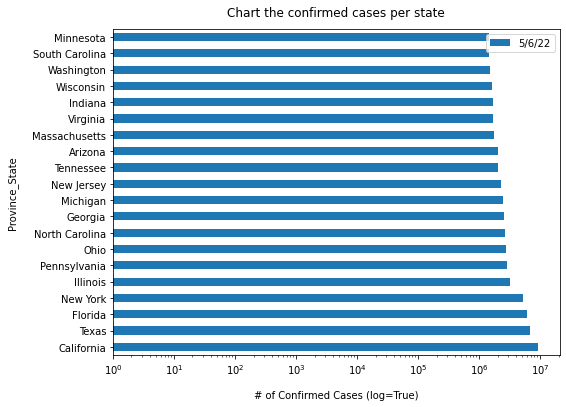

In [37]:
"""Chart the top 20 states with highest confirmed cases"""
time.sleep(3)
for d in date_list:
    clear_output(wait=True)
    top_20_per_d = usa_ts_df.groupby('Province_State')[['Province_State', d]].sum().sort_values(by=d, ascending=False).head(20)
    top_20_per_d.plot(kind='barh', log=True, figsize=(8,6))
    plt.ylabel("Province_State", labelpad=14)
    plt.xlabel("# of Confirmed Cases (log=True)", labelpad=14)
    plt.title("Chart the confirmed cases per state", y=1.02)
    plt.show()
    time.sleep(1)

### Time-series data at the country level around the world

In [38]:
world_confirmed_ts_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
world_confirmed_ts_df = pd.read_csv(world_confirmed_ts_url, header=0, escapechar='\\')
world_confirmed_ts_df.head(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,178809,178850,178873,178879,178899,178901,178901,178901,178905,178919
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,274929,275002,275055,275107,275167,275177,275191,275211,275266,275310
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,265773,265776,265779,265780,265782,265782,265782,265782,265786,265791
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,41013,41349,41349,41349,41349,41349,41349,41717,41717,41717
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,99287,99287,99287,99287,99287,99287,99287,99287,99287,99287


### Splitting records by different matching types

In [39]:
world_confirmed_ts_df[world_confirmed_ts_df["Province/State"].notna()].head(8)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
9,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,...,101899,103220,103220,104941,105739,106705,107769,108830,109879,110846
10,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,...,2254742,2266604,2278053,2287281,2294900,2304435,2316269,2334360,2345156,2356642
11,Northern Territory,Australia,-12.4634,130.8456,0,0,0,0,0,0,...,62487,62907,63289,63289,63568,64151,64540,64983,64983,65659
12,Queensland,Australia,-27.4698,153.0251,0,0,0,0,0,0,...,981974,986439,992324,997619,1002257,1007459,1015120,1023149,1030172,1036786
13,South Australia,Australia,-34.9285,138.6007,0,0,0,0,0,0,...,398505,402538,406475,409717,413321,416371,416371,424182,427205,424182
14,Tasmania,Australia,-42.8821,147.3272,0,0,0,0,0,0,...,133496,134592,135641,136457,137359,138395,139468,140554,141647,142541
15,Victoria,Australia,-37.8136,144.9631,0,0,0,0,1,1,...,1542059,1552647,1561415,1561415,1576945,1586876,1597464,1609060,1619296,1628531
16,Western Australia,Australia,-31.9505,115.8605,0,0,0,0,0,0,...,372414,380409,387111,392423,398270,405848,415563,425704,433295,442481


In [40]:
for country in ["Australia", "Canada", "China", "Denmark", "France"]:
    df = world_confirmed_ts_df[world_confirmed_ts_df["Province/State"].isna()]
    df = df[df["Country/Region"]==country]
    if df.size:
        display(df)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
105,NaN,Denmark,56.2639,9.5018,0,0,0,0,0,0,...,3113693,3114781,3115721,3116655,3117326,3118106,3119099,3120061,3120933,3121820


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
131,NaN,France,46.2276,2.2137,0,0,2,3,3,3,...,27719872,27779632,27829894,27879376,27916102,27924839,27978577,28026502,28070727,28108929


### Summarize and repair the time-series global confirmed cases

In [41]:
def sum_all_provinces_in_country(df, country):
    
    # query all sub-records of the selected country
    tmp_df = df[df["Country/Region"]==country]
    
    # create a new row which is to sum all statistics of this country, and 
    # assign the summed value of all sub-records to the date_time column of the new row
    sum_row = tmp_df.sum(axis=0)
    
    # assign the constants to the ['Province/State', 'Country/Region', 'Lat', 'Long'] columns; 
    # note that the Country/Region column will be renamed from solely the country name to country name + ", Sum".
    sum_row.loc['Province/State'] = "NaN"
    sum_row.loc['Country/Region'] = country + ", Sum"
    sum_row.loc['Lat'] = tmp_df['Lat'].values[0]
    sum_row.loc['Long'] = tmp_df['Long'].values[0]
    
    # append the new row to the original DataFrame, and 
    # remove the sub-records of the selected country.
    df = pd.concat([df, sum_row.to_frame().T], ignore_index=True)
    display(df[df["Country/Region"].str.contains(country + ", Sum")])
    df=df[df['Country/Region'] != country]
    df.loc[df['Country/Region']== country+", Sum", 'Country/Region'] = country
    
    return df

In [42]:
for country in ["Australia", "Canada", "China"]:
    world_confirmed_ts_df = sum_all_provinces_in_country(world_confirmed_ts_df, country)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
284,NaN,"Australia, Sum",-35.4735,149.0124,0,0,0,0,4,5,...,5847576,5889356,5927528,5953142,5992359,6030240,6072564,6130822,6171633,6207668


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
277,NaN,"Canada, Sum",53.9333,-116.5765,0,2,3,3,3,3,...,3741528,3750025,3762254,3765710,3768329,3770995,3776551,3787349,3794488,3803458


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
262,NaN,"China, Sum",31.8257,117.2264,548,643,920,1406,2075,2877,...,2099294,2125741,2154960,2156704,2207511,2227785,2244537,2259581,2272841,2284843


In [43]:
world_confirmed_ts_df.sort_values(by = date_list[-1], ascending = False).head(10)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
232,NaN,US,40.0,-100.0,1,1,2,2,5,5,...,81189789,81263135,81323186,81346535,81362688,81444332,81506075,81620383,81694580,81831854
124,NaN,India,20.593684,78.96288,0,0,0,0,0,0,...,43068799,43072176,43075864,43079188,43082345,43084913,43088118,43091393,43094938,43098743
23,NaN,Brazil,-14.235,-51.9253,0,0,0,0,0,0,...,30399004,30418920,30433042,30448236,30454499,30460997,30482429,30502501,30524183,30543908
107,NaN,France,46.2276,2.2137,0,0,2,3,3,3,...,27719872,27779632,27829894,27879376,27916102,27924839,27978577,28026502,28070727,28108929
111,NaN,Germany,51.165691,10.451526,0,0,0,0,0,1,...,24609159,24710769,24798067,24809785,24813817,24927339,25033970,25130137,25215210,25287462
249,NaN,United Kingdom,55.3781,-3.436,0,0,0,0,0,0,...,22011920,22025925,22038340,22038340,22038340,22038340,22073858,22090523,22102983,22114034
194,NaN,Russia,61.52401,105.318756,0,0,0,0,0,0,...,17894787,17902334,17909924,17917191,17924145,17930267,17935641,17940665,17945617,17951065
137,NaN,"Korea, South",35.907757,127.766922,1,1,2,2,3,4,...,17086626,17194616,17237878,17275649,17295733,17346753,17395791,17438068,17464782,17504334
130,NaN,Italy,41.87194,12.56738,0,0,0,0,0,0,...,16279754,16349788,16409183,16463200,16504791,16523859,16586268,16633911,16682626,16726990
231,NaN,Turkey,38.9637,35.2433,0,0,0,0,0,0,...,15026141,15028397,15030321,15032093,15033573,15034917,15036110,15037242,15038495,15040238


In [96]:
# a simplified list
world_confirmed_ts_df[['Country/Region', date_list[-1]]].sort_values(by = date_list[-1], ascending = False).head(10)

,Country/Region,5/6/22
232,US,81831854
124,India,43098743
23,Brazil,30543908
107,France,28108929
111,Germany,25287462
249,United Kingdom,22114034
194,Russia,17951065
137,"Korea, South",17504334
130,Italy,16726990
231,Turkey,15040238


### Chart the confirmed cases per country

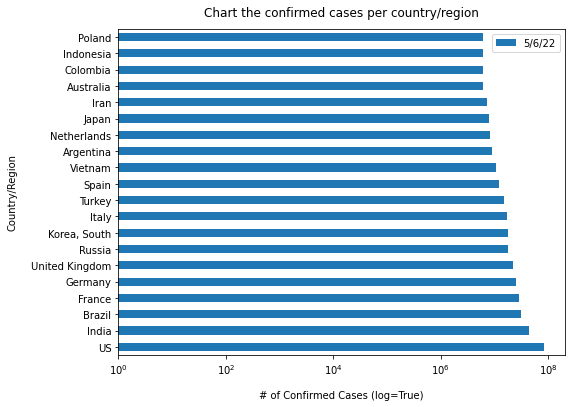

In [48]:
"""Chart the top 20 countries with highest confirmed cases"""
time.sleep(3)
for d in date_list:
    clear_output(wait=True)
    top_20_per_d = world_confirmed_ts_df.groupby('Country/Region')[['Country/Region', d]].sum().sort_values(by=d, ascending=False).head(20)
    top_20_per_d.plot(kind='barh', log=True, figsize=(8,6))
    plt.ylabel("Country/Region", labelpad=14)
    plt.xlabel("# of Confirmed Cases (log=True)", labelpad=14)
    plt.title("Chart the confirmed cases per country/region", y=1.02)
    plt.show()
    time.sleep(1)

### Summarize and repair the time-series COVID-19 deaths globally

In [49]:
world_deaths_ts_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
world_deaths_ts_df = pd.read_csv(world_deaths_ts_url, header=0, escapechar='\\')
world_deaths_ts_df.head(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,7683,7683,7683,7683,7683,7683,7683,7683,7684,7684
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,6875,6875,6875,6875,6875,6875,6875,6875,6875,6875
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,153,153,153,153,153,153,153,153,153,153
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,1900,1900,1900,1900,1900,1900,1900,1900,1900,1900


In [50]:
for country in ["Australia", "Canada", "China"]:
    world_deaths_ts_df = sum_all_provinces_in_country(world_deaths_ts_df, country)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
284,NaN,"Australia, Sum",-35.4735,149.0124,0,0,0,0,0,0,...,7164,7187,7236,7250,7244,7310,7355,7423,7453,7495


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
277,NaN,"Canada, Sum",53.9333,-116.5765,0,0,0,0,0,0,...,39056,39189,39278,39312,39334,39338,39391,39529,39682,39764


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
262,NaN,"China, Sum",31.8257,117.2264,17,18,26,42,56,82,...,14158,14210,14273,14368,14405,14430,14453,14469,14486,14510


In [51]:
world_deaths_ts_df.sort_values(by = date_list[-1], ascending = False).head(10)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
232,NaN,US,40.0,-100.0,0,0,0,0,0,0,...,992808,993164,993588,993712,993733,993999,994744,996704,996964,997318
23,NaN,Brazil,-14.235,-51.9253,0,0,0,0,0,0,...,663350,663464,663649,663736,663752,663838,663930,663994,664131,664326
124,NaN,India,20.593684,78.96288,0,0,0,0,0,0,...,523693,523753,523803,523843,523869,523889,523920,523975,524002,524024
194,NaN,Russia,61.52401,105.318756,0,0,0,0,0,0,...,367850,368011,368166,368319,368463,368595,368716,368840,368974,369106
160,NaN,Mexico,23.6345,-102.5528,0,0,0,0,0,0,...,324221,324254,324294,324334,324334,324350,324334,324334,324334,324334
188,NaN,Peru,-9.19,-75.0152,0,0,0,0,0,0,...,212778,212798,212810,212810,212841,212865,212877,212891,212906,212906
249,NaN,United Kingdom,55.3781,-3.436,0,0,0,0,0,0,...,174448,174696,174912,174912,174912,174912,175319,175546,175984,176212
130,NaN,Italy,41.87194,12.56738,0,0,0,0,0,0,...,163113,163244,163377,163507,163612,163736,163889,164041,164179,164304
125,NaN,Indonesia,-0.7893,113.9213,0,0,0,0,0,0,...,156199,156217,156240,156257,156273,156287,156305,156321,156340,156357
107,NaN,France,46.2276,2.2137,0,0,0,0,0,0,...,142389,142521,142678,142739,142771,142951,143062,143176,143298,143408


In [52]:
# a simplified view
world_deaths_ts_df[['Country/Region', date_list[-1]]].sort_values(by = date_list[-1], ascending = False).head(10)

,Country/Region,5/6/22
232,US,997318
23,Brazil,664326
124,India,524024
194,Russia,369106
160,Mexico,324334
188,Peru,212906
249,United Kingdom,176212
130,Italy,164304
125,Indonesia,156357
107,France,143408


### Summarize and repair the time-series global recovered cases

In [53]:
world_recovered_ts_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
world_recovered_ts_df = pd.read_csv(world_recovered_ts_url, header=0, escapechar='\\')
world_recovered_ts_df.head(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
for country in ["Australia", "Canada", "China"]:
    world_recovered_ts_df = sum_all_provinces_in_country(world_recovered_ts_df, country)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
269,NaN,"Australia, Sum",-35.4735,149.0124,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
262,NaN,"Canada, Sum",56.1304,-106.3468,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
262,NaN,"China, Sum",31.8257,117.2264,28,30,36,39,49,58,...,0,0,0,0,0,0,0,0,0,0


In [55]:
world_recovered_ts_df.sort_values(by = date_list[-1], ascending = False).head(10)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/27/22,4/28/22,4/29/22,4/30/22,5/1/22,5/2/22,5/3/22,5/4/22,5/5/22,5/6/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
178,NaN,Niger,17.607789,8.081666,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
180,NaN,North Macedonia,41.6086,21.7453,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181,NaN,Norway,60.472,8.4689,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
182,NaN,Oman,21.512583,55.923255,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
183,NaN,Pakistan,30.3753,69.3451,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
184,NaN,Palau,7.515,134.5825,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
185,NaN,Panama,8.538,-80.7821,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
186,NaN,Papua New Guinea,-6.314993,143.95555,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
187,NaN,Paraguay,-23.4425,-58.4438,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# a simplfied view
world_recovered_ts_df[['Country/Region', date_list[-1]]].sort_values(by = date_list[-1], ascending = False).head(10)

,Country/Region,5/6/22
0,Afghanistan,0
178,Niger,0
180,North Macedonia,0
181,Norway,0
182,Oman,0
183,Pakistan,0
184,Palau,0
185,Panama,0
186,Papua New Guinea,0
187,Paraguay,0


### Predictive Analysis

In [57]:
usa_overall_confirmed_ts_df = world_confirmed_ts_df[world_confirmed_ts_df["Country/Region"] == "US"]
new_usa_confirmed_df = usa_overall_confirmed_ts_df[date_list].T
new_usa_confirmed_df.columns = ["confirmed"]
new_usa_confirmed_df = new_usa_confirmed_df.assign(days=[1 + 
                                               i for i in range(len(new_usa_confirmed_df))])[['days'] + 
                                               new_usa_confirmed_df.columns.tolist()]
new_usa_confirmed_df

,days,confirmed
1/22/20,1,1
1/23/20,2,1
1/24/20,3,2
1/25/20,4,2
1/26/20,5,5
...,...,...
5/2/22,832,81444332
5/3/22,833,81506075
5/4/22,834,81620383
5/5/22,835,81694580


In [58]:
usa_overall_deaths_ts_df = world_deaths_ts_df[world_deaths_ts_df["Country/Region"] == "US"]
new_usa_deaths_df = usa_overall_deaths_ts_df[date_list].T
new_usa_deaths_df.columns = ["deaths"]
new_usa_deaths_df = new_usa_deaths_df.assign(days=[1 +
                                                   i for i in range(len(new_usa_deaths_df))])[['days'] + 
                                                   new_usa_deaths_df.columns.tolist()]
new_usa_deaths_df

,days,deaths
1/22/20,1,0
1/23/20,2,0
1/24/20,3,0
1/25/20,4,0
1/26/20,5,0
...,...,...
5/2/22,832,993999
5/3/22,833,994744
5/4/22,834,996704
5/5/22,835,996964


In [59]:
usa_overall_recovered_ts_df = world_recovered_ts_df[world_recovered_ts_df["Country/Region"] == "US"]
new_usa_recovered_df = usa_overall_recovered_ts_df[date_list].T
new_usa_recovered_df.columns = ["recovered"]
new_usa_recovered_df = new_usa_recovered_df.assign(days=[1 +
                                                         i for i in range(len(new_usa_recovered_df))])[['days'] + 
                                                         new_usa_recovered_df.columns.tolist()]
new_usa_recovered_df

,days,recovered
1/22/20,1,0
1/23/20,2,0
1/24/20,3,0
1/25/20,4,0
1/26/20,5,0
...,...,...
5/2/22,832,0
5/3/22,833,0
5/4/22,834,0
5/5/22,835,0


In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

class PolynomialRegressionModel:

    def __init__(self, model_name, polynomial_degree):
        self.__model_name = model_name
        self.__polynomial_degree = polynomial_degree
        self.__model = None

    def train(self, x, y):
        polynomial_features = PolynomialFeatures(degree=self.__polynomial_degree)
        x_poly = polynomial_features.fit_transform(x)
        self.__model = LinearRegression()
        self.__model.fit(x_poly, y)

    def get_predictions(self, x):
        polynomial_features = PolynomialFeatures(degree=self.__polynomial_degree)
        x_poly = polynomial_features.fit_transform(x)
        return np.round(self.__model.predict(x_poly), 0).astype(np.int32)

    def get_model_polynomial_str(self):
        coef = self.__model.coef_
        intercept = self.__model.intercept_
        poly = "{0:.3f}".format(intercept)

        for i in range(1, len(coef)):
            if coef[i] >= 0:
                poly += " + "
            else:
                poly += " - "
            poly += "{0:.3f}".format(coef[i]).replace("-", "") + "X^" + str(i)

        return poly

In [61]:
training_set = new_usa_confirmed_df
x = np.array(training_set["days"]).reshape(-1, 1)
y = training_set["confirmed"]

In [62]:
training_set_deaths = new_usa_deaths_df
x_deaths = np.array(training_set_deaths["days"]).reshape(-1, 1)
y_deaths = training_set_deaths["deaths"]

### Polynomial Regression

#### Confirmed Cases with PR model

#### degrees = 2

In [63]:
regression_model = PolynomialRegressionModel("Cases using Polynomial Regression", 2)
regression_model.train(x, y)

In [64]:
y_pred = regression_model.get_predictions(x)
y_pred

array([-1091892, -1075128, -1058161, -1040991, -1023620, -1006045,
        -988268,  -970289,  -952107,  -933723,  -915136,  -896347,
        -877355,  -858161,  -838764,  -819164,  -799363,  -779358,
        -759151,  -738742,  -718130,  -697316,  -676299,  -655080,
        -633658,  -612034,  -590207,  -568178,  -545946,  -523512,
        -500875,  -478036,  -454994,  -431750,  -408303,  -384654,
        -360802,  -336747,  -312491,  -288031,  -263370,  -238505,
        -213439,  -188169,  -162698,  -137024,  -111147,   -85068,
         -58786,   -32302,    -5615,    21274,    48366,    75660,
         103157,   130856,   158758,   186862,   215169,   243678,
         272390,   301304,   330421,   359740,   389262,   418986,
         448912,   479042,   509373,   539907,   570644,   601583,
         632725,   664069,   695616,   727365,   759317,   791471,
         823827,   856386,   889148,   922112,   955279,   988648,
        1022220,  1055994,  1089970,  1124150,  1158531,  1193

In [65]:
def print_forecast(model_name, model, beginning_day=0, limit=10):

    next_days_x = np.array(range(beginning_day, beginning_day + limit)).reshape(-1, 1)
    next_days_pred = model.get_predictions(next_days_x)

    print("The forecast for " + model_name + " in the following " + str(limit) + " days is:")
    for i in range(0, limit):
        print("Day " + str(i + 1) + ": " + str(next_days_pred[i]))

In [66]:
print_forecast("Cases using Polynomial Regression", regression_model, 
               beginning_day=len(x), 
               limit=10)

The forecast for Cases using Polynomial Regression in the following 10 days is:
Day 1: 83414881
Day 2: 83600730
Day 3: 83786782
Day 4: 83973037
Day 5: 84159494
Day 6: 84346154
Day 7: 84533016
Day 8: 84720080
Day 9: 84907347
Day 10: 85094817


In [67]:

import operator

def plot_graph(model_name, x, y, y_pred):

    plt.scatter(x, y, s=10)
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(x, y_pred), key=sort_axis)
    x, y_pred = zip(*sorted_zip)

    plt.plot(x, y_pred, color='m')
    plt.title("Amount of " + model_name + " in each day")
    plt.xlabel("Day")
    plt.ylabel(model_name)
    plt.show()

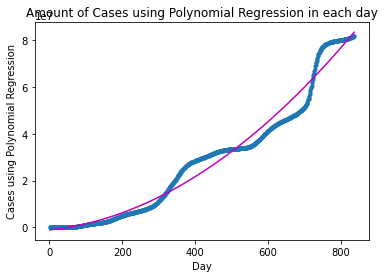

In [68]:

plot_graph("Cases using Polynomial Regression", x, y, y_pred)

#### degrees = 3

The forecast for Confirmed cases using Polynomial Regression (d=3) in the following 10 days is:
Day 1: 86347377
Day 2: 86575624
Day 3: 86804327
Day 4: 87033487
Day 5: 87263104
Day 6: 87493180
Day 7: 87723714
Day 8: 87954708
Day 9: 88186162
Day 10: 88418076


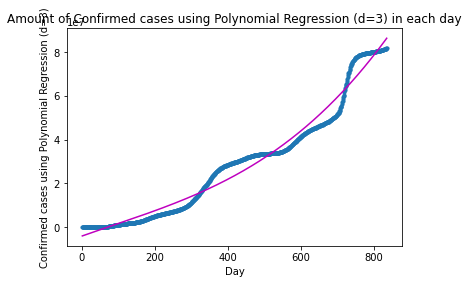

In [69]:
regression_model = PolynomialRegressionModel("Confirmed cases using Polynomial Regression (d=3)", 3)
regression_model.train(x, y)
y_pred = regression_model.get_predictions(x)
print_forecast("Confirmed cases using Polynomial Regression (d=3)", regression_model, 
               beginning_day=len(x), 
               limit=10)
plot_graph("Confirmed cases using Polynomial Regression (d=3)", x, y, y_pred)

#### Deaths with PR

#### Degrees = 2

The forecast for Deaths using Polynomial Regression in the following 10 days is:
Day 1: 1016395
Day 2: 1017793
Day 3: 1019191
Day 4: 1020589
Day 5: 1021988
Day 6: 1023387
Day 7: 1024787
Day 8: 1026186
Day 9: 1027586
Day 10: 1028986


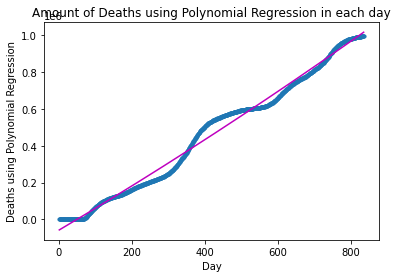

In [70]:
regression_model = PolynomialRegressionModel("Deaths using Polynomial Regression", 2)
regression_model.train(x_deaths, y_deaths)
y_deaths_pred = regression_model.get_predictions(x_deaths)
print_forecast("Deaths using Polynomial Regression", regression_model, 
               beginning_day=len(x_deaths), 
               limit=10)
plot_graph("Deaths using Polynomial Regression", x_deaths, y_deaths, y_deaths_pred)

The forecast for Deaths using Polynomial Regression (d=3) in the following 10 days is:
Day 1: 999840
Day 2: 1000998
Day 3: 1002156
Day 4: 1003312
Day 5: 1004467
Day 6: 1005621
Day 7: 1006774
Day 8: 1007925
Day 9: 1009076
Day 10: 1010225


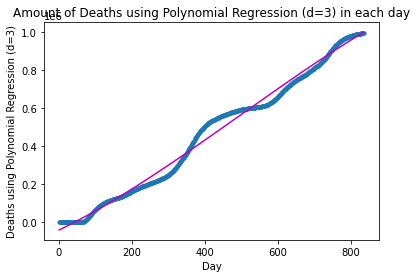

In [71]:
regression_model = PolynomialRegressionModel("Deaths using Polynomial Regression (d=3)", 3)
regression_model.train(x_deaths, y_deaths)
y_deaths_pred = regression_model.get_predictions(x_deaths)
print_forecast("Deaths using Polynomial Regression (d=3)", regression_model, 
               beginning_day=len(x_deaths), 
               limit=10)
plot_graph("Deaths using Polynomial Regression (d=3)", x_deaths, y_deaths, y_deaths_pred)

### Neural Network

#### Confirmed Cases with NN

In [72]:
from sklearn.neural_network import MLPRegressor

class NeuralNetModel:

    def __init__(self, model_name):
        self.__model_name = model_name
        self.__model = None

    def train(self, x, y, hidden_layer_sizes=[10,], learning_rate=0.001, max_iter=2000):
        self.__model = MLPRegressor(solver="adam", activation="relu", alpha=1e-5, random_state=0, 
                                    hidden_layer_sizes=hidden_layer_sizes, verbose=False, tol=1e-5, 
                                    learning_rate_init=learning_rate, max_iter=max_iter)
        self.__model.fit(x, y)

    def get_predictions(self, x):
        return np.round(self.__model.predict(x), 0).astype(np.int32)

In [73]:
neural_net_model = NeuralNetModel("Confirmed Cases using Neural Network")
neural_net_model.train(x, y, [80, 80], 0.001, 50000)

In [74]:
y_pred = neural_net_model.get_predictions(x)
y_pred

array([   83242,   160886,   238530,   316174,   393818,   471462,
         549107,   626751,   704395,   782039,   859683,   937325,
        1014967,  1092608,  1170245,  1247881,  1325516,  1403152,
        1480785,  1558417,  1636049,  1713682,  1791314,  1868946,
        1946578,  2024211,  2101843,  2179475,  2257107,  2334740,
        2412372,  2490004,  2567636,  2645269,  2722901,  2800533,
        2878165,  2955798,  3033430,  3111062,  3188694,  3266327,
        3343959,  3421591,  3499223,  3576856,  3654488,  3732120,
        3809752,  3887385,  3965017,  4042649,  4120281,  4197914,
        4275546,  4353178,  4430810,  4508442,  4586074,  4663706,
        4741338,  4818969,  4896601,  4974233,  5051865,  5129497,
        5207129,  5284760,  5362392,  5440024,  5517656,  5595288,
        5672919,  5750551,  5828183,  5905815,  5983447,  6061078,
        6138710,  6216342,  6293974,  6371606,  6449238,  6526869,
        6604501,  6682133,  6759765,  6837397,  6915028,  6992

In [75]:
print_forecast("Confirmed Cases using Neural Network", neural_net_model, 
               beginning_day=len(x), 
               limit=10)

The forecast for Confirmed Cases using Neural Network in the following 10 days is:
Day 1: 64905992
Day 2: 64983624
Day 3: 65061256
Day 4: 65138887
Day 5: 65216519
Day 6: 65294151
Day 7: 65371783
Day 8: 65449415
Day 9: 65527046
Day 10: 65604678


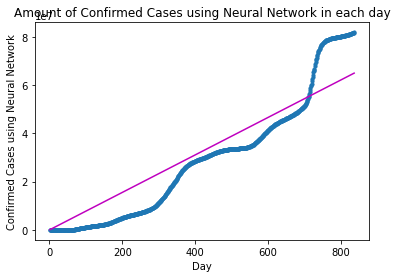

In [76]:
plot_graph("Confirmed Cases using Neural Network", x, y, y_pred)

#### Deaths with NN

The forecast for Deaths using Neural Network in the following 10 days is:
Day 1: 1000633
Day 2: 1001914
Day 3: 1003195
Day 4: 1004476
Day 5: 1005757
Day 6: 1007038
Day 7: 1008319
Day 8: 1009600
Day 9: 1010881
Day 10: 1012162


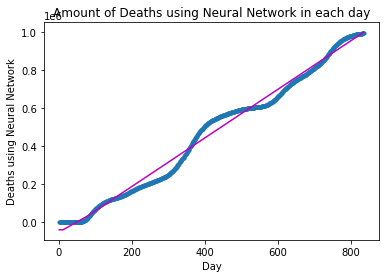

In [77]:
neural_net_model = NeuralNetModel("Deaths using Neural Network")
neural_net_model.train(x_deaths, y_deaths, [100, 100], 0.001, 50000)
y_deaths_pred = neural_net_model.get_predictions(x_deaths)
print_forecast("Deaths using Neural Network", neural_net_model, 
               beginning_day=len(x_deaths), 
               limit=10)
plot_graph("Deaths using Neural Network", x_deaths, y_deaths, y_deaths_pred)

## SIR Model

#### Basic Reproduction Number

#### Fit the SIR Model per country

In [ ]:
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from datetime import timedelta, datetime

"""The dict defined here includes the countries to run the model against,
   and the date that after two years from the first confirmed case was reported.
   (too much data to run out if using the data of first confirmed case)
"""
START_DATE = {
  'China': '5/22/21',
  'Japan': '5/22/21',
  'Korea, South': '5/22/21',
  'US': '5/22/21',
  'Italy': '5/31/21',
  'Spain': '7/1/21',
  'Iran': '7/19/21'
}

In [121]:

# Adding into the consideration the social distancing factor (to be explained in the next section)
rho = 1

In [122]:
class Learner(object):
    """constructs an SIR model learner to load training set, train the model,
       and make predictions at country level.
    """
    def __init__(self, country, loss, start_date, predict_range,s_0, i_0, r_0):
        self.country = country
        self.loss = loss
        self.start_date = start_date
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0

    def load_confirmed(self, country):
      """
      Load confirmed cases downloaded from pre-made dataframe
      """
      country_df = world_confirmed_ts_df[world_confirmed_ts_df["Country/Region"] == country]
      return country_df.iloc[0].loc[START_DATE[country]:]

    def load_dead(self, country):
      """
      Load deaths downloaded from pre-made dataframe
      """
      country_df = world_deaths_ts_df[world_deaths_ts_df["Country/Region"] == country]
      return country_df.iloc[0].loc[START_DATE[country]:]

    def load_recovered(self, country):
      """
      Load recovered cases downloaded from pre-made dataframe
      """
      country_df = world_recovered_ts_df[world_recovered_ts_df["Country/Region"] == country]
      return country_df.iloc[0].loc[START_DATE[country]:]

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict_0(self, beta, gamma, data):
        """
        Simplifield version.
        Predict how the number of people in each compartment can be changed through time toward the future.
        The model is formulated with the given beta and gamma.
        """
        predict_range = 150
        new_index = self.extend_index(data.index, predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-rho*beta*S*I, rho*beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        return new_index, extended_actual, solve_ivp(SIR, [0, size], [S_0,I_0,R_0], t_eval=np.arange(0, size, 1))
    
    def predict(self, beta, gamma, data, recovered, death, country, s_0, i_0, r_0):
        """
        Predict how the number of people in each compartment can be changed through time toward the future.
        The model is formulated with the given beta and gamma.
        """
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)

        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-rho*beta*S*I, rho*beta*S*I-gamma*I, gamma*I]

        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
        solved = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))
        return new_index, extended_actual, extended_recovered, extended_death, solved

    def train_0(self):
        """
        Simplified version.
        Run the optimization to estimate the beta and gamma fitting the given confirmed cases.
        """
        data = self.load_confirmed(self.country)
        optimal = minimize(
            loss,
            [0.001, 0.001],
            args=(data),
            method='L-BFGS-B',
            bounds=[(0.00000001, 0.4), (0.00000001, 0.4)]
        )
        beta, gamma = optimal.x
        new_index, extended_actual, prediction = self.predict(beta, gamma, data)
        df = pd.DataFrame({
            'Actual': extended_actual,
            'S': prediction.y[0],
            'I': prediction.y[1],
            'R': prediction.y[2]
        }, index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(self.country)
        df.plot(ax=ax)
        fig.savefig(f"{self.country}.png")
        
    def train(self):
        """
        Run the optimization to estimate the beta and gamma fitting the given confirmed cases.
        """
        recovered = self.load_recovered(self.country)
        death = self.load_dead(self.country)
        data = (self.load_confirmed(self.country) - recovered - death)

        optimal = minimize(loss, [0.001, 0.001], 
                           args=(data, recovered, self.s_0, self.i_0, self.r_0), 
                           method='L-BFGS-B', 
                           bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
        print(optimal)

        beta, gamma = optimal.x
        new_index, extended_actual, extended_recovered, extended_death, prediction = self.predict(beta, gamma, data, 
                                                                                                  recovered, death, 
                                                                                                  self.country, self.s_0, 
                                                                                                  self.i_0, self.r_0)
        df = pd.DataFrame({'Infected data': extended_actual, 'Recovered data': extended_recovered, 
                           'Death data': extended_death, 'Susceptible': prediction.y[0], 
                           'Infected': prediction.y[1], 'Recovered': prediction.y[2]}, index=new_index)

        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(self.country)
        df.plot(ax=ax)
        print(f"country={self.country}, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
        fig.savefig(f"{self.country}.png")

In [123]:
def loss(point, data, recovered, s_0, i_0, r_0):

    size = len(data)
    beta, gamma = point

    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-rho*beta*S*I, rho*beta*S*I-gamma*I, gamma*I]

    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1

    return alpha * l1 + (1 - alpha) * l2

#### The initial batch of SIR Model fitting

In [125]:
START_DATE1 = {
  'China': '1/1/22',
  'Japan': '1/1/22',
  'Korea, South': '1/1/22',
  'US': '1/1/22',
  'Italy': '1/1/22',
  'Spain': '1/1/22',
  'Iran': '1/1/22'
}

In [ ]:
countries = ['China', 'Korea, South']
predict_range = 250
s_0 = 100000
i_0 = 2
r_0 = 10

for country in countries:
    start_date = START_DATE1[country]
    learner = Learner(country, loss, start_date, predict_range, s_0, i_0, r_0)
    learner.train()

In [ ]:
countries = ['Japan', 'Italy', 'Spain']
predict_range = 250
s_0 = 100000
i_0 = 2
r_0 = 10

for country in countries:
    start_date = START_DATE1[country]
    learner = Learner(country, loss, start_date, predict_range, s_0, i_0, r_0)
    learner.train()

In [ ]:
predict_range = 250
s_0 = 100000
i_0 = 2
r_0 = 10

country="US"
start_date = START_DATE1[country]
learner = Learner(country, loss, start_date, predict_range, s_0, i_0, r_0)
learner.train()

In [ ]:
predict_range = 250
s_0 = 25000
i_0 = 2
r_0 = 10

country="Japan"
start_date = START_DATE1[country]
learner = Learner(country, loss, start_date, predict_range, s_0, i_0, r_0)
learner.train()

In [ ]:
countries = ['Korea, South', 'US']
predict_range = 250
s_0_values = [25000, 1000000]
i_0 = 2
r_0 = 10

for country, s_0 in zip(countries, s_0_values):
    start_date = START_DATE1[country]
    learner = Learner(country, loss, start_date, predict_range, s_0, i_0, r_0)
    learner.train()

#### The final batch of SIR Model fitting

In [ ]:
predict_range = 250
s_0 = 2000000
i_0 = 2
r_0 = 10

country="US"
start_date = START_DATE[country]
learner = Learner(country, loss, start_date, predict_range, s_0, i_0, r_0)
learner.train()

In [ ]:
predict_range = 250
s_0 = 3000000
i_0 = 2
r_0 = 10

country="US"
start_date = START_DATE[country]
learner = Learner(country, loss, start_date, predict_range, s_0, i_0, r_0)
learner.train()

In [ ]:
predict_range = 250
s_0 = 3500000
i_0 = 2
r_0 = 10

country="US"
start_date = START_DATE[country]
learner = Learner(country, loss, start_date, predict_range, s_0, i_0, r_0)
learner.train()

In [ ]:
predict_range = 250
s_0 = 4000000
i_0 = 2
r_0 = 10

country="US"
start_date = START_DATE[country]
learner = Learner(country, loss, start_date, predict_range, s_0, i_0, r_0)
learner.train()

### Consider the social distancing effect in SIR Model fitting

In [ ]:
rho = 0.8

In [ ]:
predict_range = 250
s_0 = 3500000
i_0 = 2
r_0 = 10

country="US"
start_date = START_DATE[country]
learner = Learner(country, loss, start_date, predict_range, s_0, i_0, r_0)
learner.train()